# Experience Analysis

In [3]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

# Print connection details (without password)
print(f"Attempting to connect to:")
print(f"Database: {os.getenv('DB_NAME')}")
print(f"User: {os.getenv('DB_USER')}")
print(f"Host: {os.getenv('DB_HOST')}")
print(f"Port: {os.getenv('DB_PORT')}")

try:
    conn = psycopg2.connect(
        dbname=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        host=os.getenv('DB_HOST'),
        port=os.getenv('DB_PORT')
    )
    print("Successfully connected to database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to connect to:
Database: telecom_db
User: postgres
Host: localhost
Port: 5432
Successfully connected to database!


### Load the XDR data with error checking

In [4]:
import pandas as pd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append('../scripts')  # Add scripts folder to Python path
from visualization_utils import plot_histogram, plot_boxplot, plot_heatmap, scatter_pca, plot_pie_chart, plot_bar_chart
from load_data import load_table_to_dataframe # to load the data
# Load the XDR data with error checking
xdr_data = load_table_to_dataframe("xdr_data")
if xdr_data is None:
    print("Failed to load data. Please check:")
    print("1. Database connection settings in .env file")
    print("2. Database is running and accessible")
    print("3. Table 'xdr_data' exists in the database")
else:
    print(xdr_data.head())


/home/bbm/Documents/projects/Telecom-Data-Analysis/notebooks/../scripts/load_data.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

### Aggregate Metrics

   MSISDN/Number  TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
0   3.360100e+10                 1.685339e+07        46.000000   
1   3.360100e+10                 1.685339e+07        30.000000   
2   3.360100e+10                 1.685339e+07       119.182869   
3   3.360101e+10                 1.066000e+03        69.000000   
4   3.360101e+10                 9.349630e+06        57.000000   

   Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  \
0         0.000000                     37.0                     39.0   
1         1.000000                     48.0                     51.0   
2        16.771129                     48.0                     49.0   
3        15.000000                    204.0                     44.0   
4         2.500000                  20197.5                   8224.5   

                     Handset Type  
0  Huawei P20 Lite Huawei Nova 3E  
1          Apple iPhone 7 (A1778)  
2                       undefined  
3         Apple iPhone 5S 

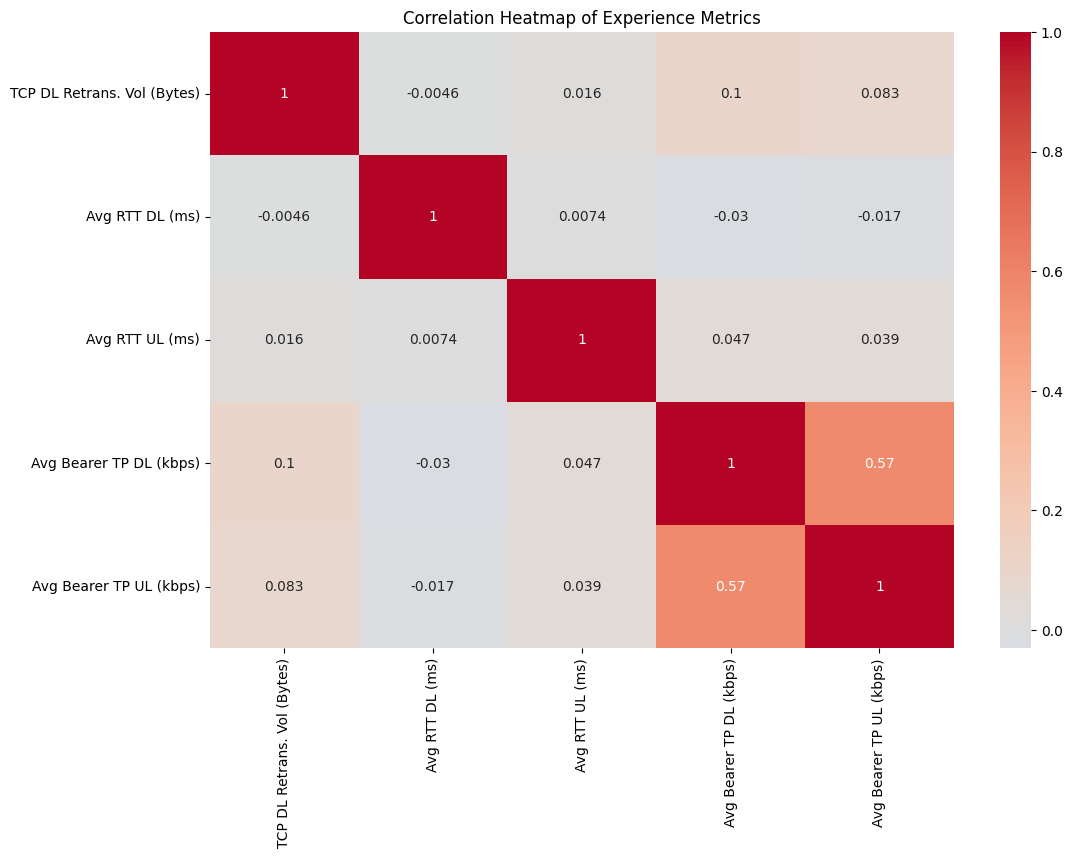

In [5]:
# Aggregate metrics per customer (MSISDN)
experience_data = xdr_data.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',  # Average TCP retransmission
    'Avg RTT DL (ms)': 'mean',             # Average RTT (Download)
    'Avg RTT UL (ms)': 'mean',             # Average RTT (Upload)
    'Avg Bearer TP DL (kbps)': 'mean',     # Average Throughput (Download)
    'Avg Bearer TP UL (kbps)': 'mean',     # Average Throughput (Upload)
    'Handset Type': lambda x: x.mode()[0] if not x.mode().empty else None  # Most common Handset Type
}).reset_index()

# Handle missing values by replacing with column mean or mode
experience_data.fillna(experience_data.mean(numeric_only=True), inplace=True)

print(experience_data.head())

# Visualization

# Create correlation heatmap to show relationships between all numeric metrics
numeric_cols = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 
               'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']
plot_heatmap(experience_data[numeric_cols].corr(), 'Correlation Heatmap of Experience Metrics')
plt.show()


### Analyze Metrics

In [6]:
# Top and bottom 10 for TCP, RTT, and Throughput
for col in ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']:
    print(f"Top 10 {col}:")
    print(experience_data.nlargest(10, col)[['MSISDN/Number', col]])
    
    print(f"Bottom 10 {col}:")
    print(experience_data.nsmallest(10, col)[['MSISDN/Number', col]])
    print()

# Most frequent handset types
print("Most Frequent Handset Types:")
print(experience_data['Handset Type'].value_counts().head(10))

Top 10 TCP DL Retrans. Vol (Bytes):
       MSISDN/Number  TCP DL Retrans. Vol (Bytes)
85785   3.369858e+10                 4.289488e+09
32273   3.365871e+10                 4.288060e+09
58026   3.366491e+10                 4.268432e+09
31942   3.365863e+10                 4.254644e+09
62049   3.366613e+10                 4.211189e+09
70079   3.366877e+10                 4.166591e+09
43629   3.366131e+10                 4.131046e+09
48341   3.366240e+10                 4.117753e+09
64113   3.366682e+10                 3.968072e+09
98211   3.376264e+10                 3.785295e+09
Bottom 10 TCP DL Retrans. Vol (Bytes):
        MSISDN/Number  TCP DL Retrans. Vol (Bytes)
56622    3.366454e+10                          2.0
95322    3.376154e+10                          2.0
71705    3.366931e+10                          4.0
71778    3.366933e+10                          4.0
87156    3.369900e+10                          4.0
87348    3.369906e+10                          4.0
95213    3.376151e

### Distribution Analysis



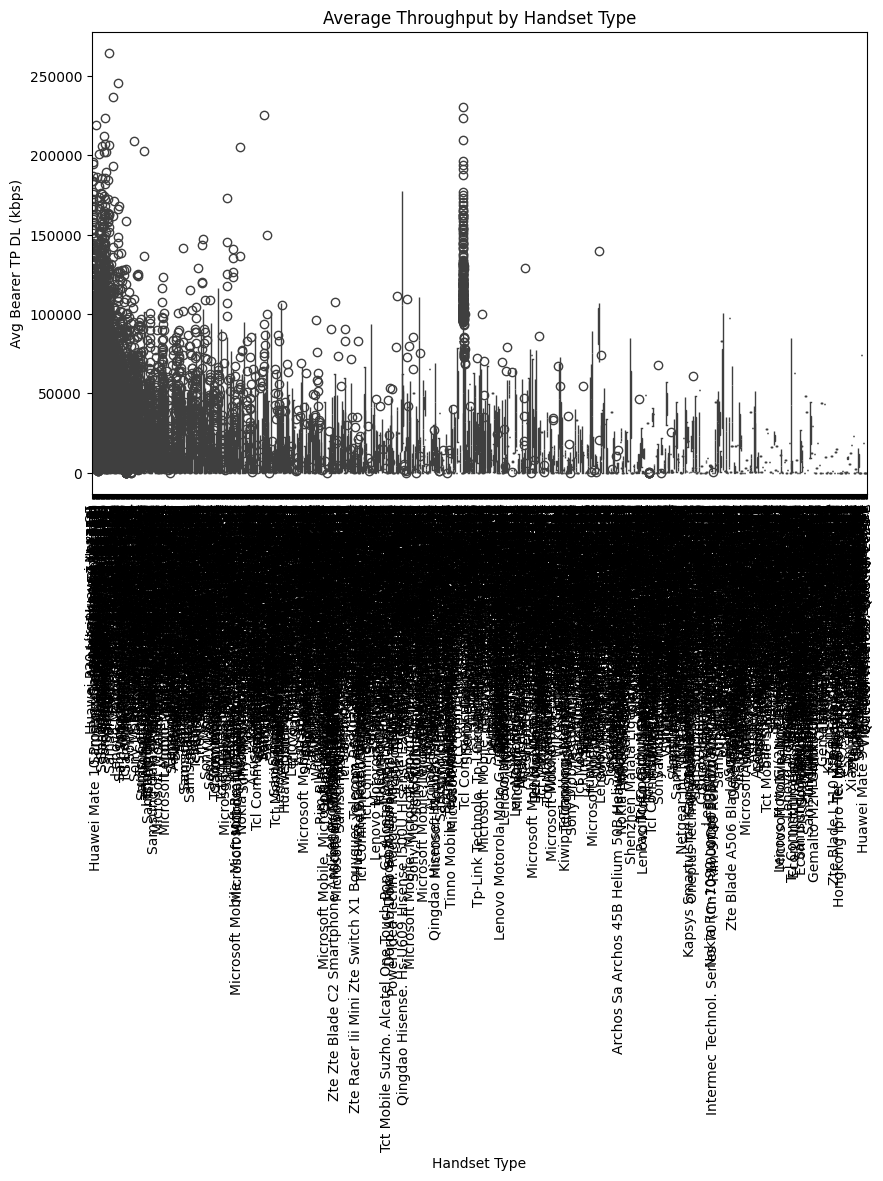

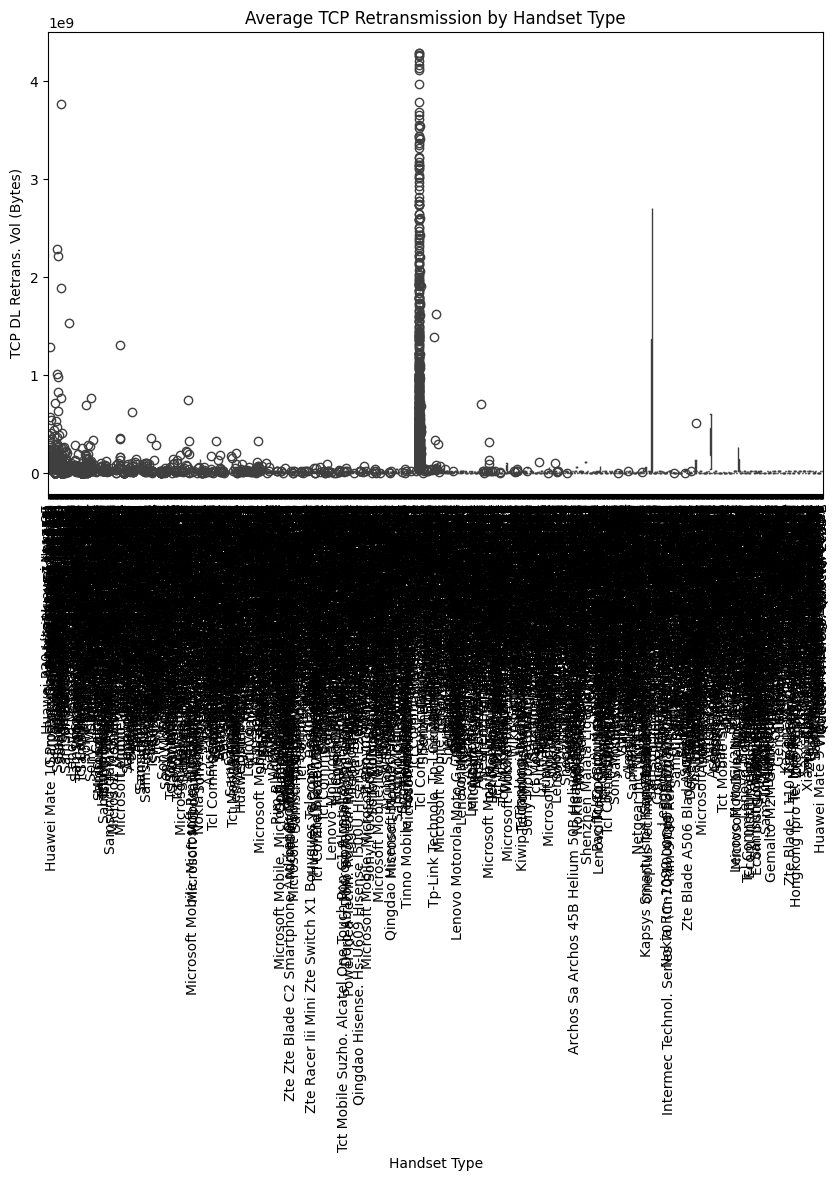

In [7]:
# Distribution of Average Throughput by Handset Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=experience_data, x='Handset Type', y='Avg Bearer TP DL (kbps)')
plt.title("Average Throughput by Handset Type")
plt.xticks(rotation=90)
plt.show()

# Distribution of Average TCP Retransmission by Handset Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=experience_data, x='Handset Type', y='TCP DL Retrans. Vol (Bytes)')
plt.title("Average TCP Retransmission by Handset Type")
plt.xticks(rotation=90)
plt.show()

### K-Means Clustering for Experience Groups


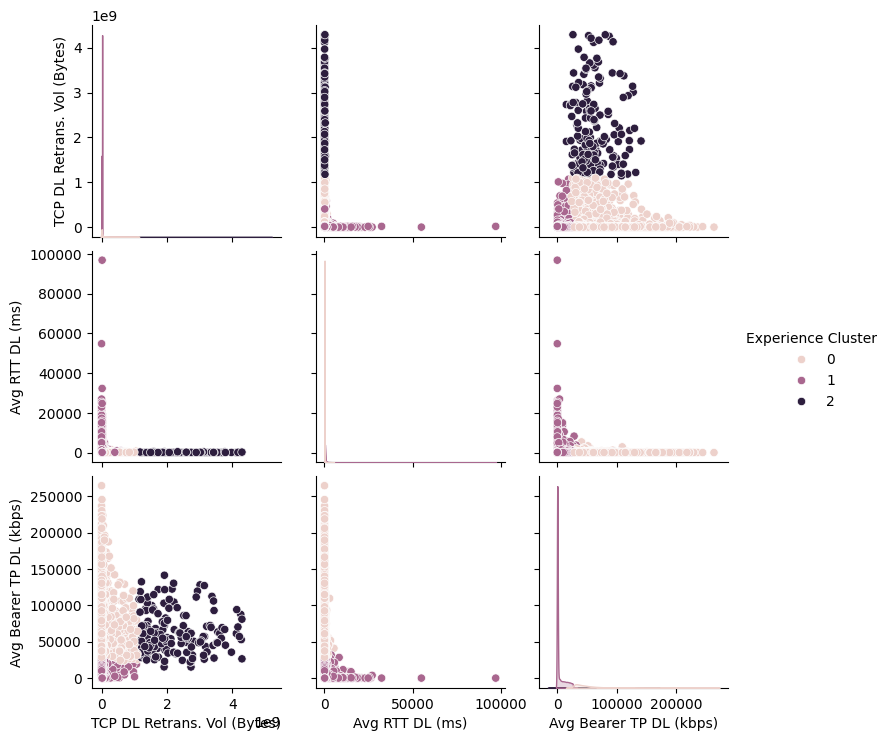

In [8]:
from sklearn.cluster import KMeans

# Selecting relevant features
features = experience_data[['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']].fillna(0)

# Standardizing data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
experience_data['Experience Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clustering results
sns.pairplot(data=experience_data, vars=['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)'], hue='Experience Cluster')
plt.show()